In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
from sklearn import metrics
from sklearn import linear_model
from sklearn import ensemble
import xgboost as xgb

In [2]:
#load the data direct from google  
url = 'https://docs.google.com/spreadsheets/d/1CB9DNY-5xbMZtP_xFhQJtVO4aqh14VCe6L2yDor4Czc/export?format=csv&gid=31965918'

df = pd.read_csv(url, parse_dates=['Timestamp'])

# Reset the columns to something more useable
df.columns = ['timestamp', 'designation','signup','sigils', 'emailP1',
              'p1SameEmail','sendEmail','mercuryVote','p2survey','onlineName',
              'lucidDream','curious','echo','coincidence','lifeAsGame',
              'universeBeginning','simulation','singularity','physicalPass',
              'secondSurvey','truth','redButton','surprise','whichFirst',
              'datasetSurvey','dsAlone','finalQ','numPics','citizenID','cityOnMap',
              'bootsectorCode','azureCode','nyLive','multiEmail','communities',
              'enarc','enarcSameEmail','wtComplete','steamKey','activity','numPplGuess']

In [3]:
#lets have a looky
df.head()

,timestamp,designation,signup,sigils,emailP1,p1SameEmail,sendEmail,mercuryVote,p2survey,onlineName,...,azureCode,nyLive,multiEmail,communities,enarc,enarcSameEmail,wtComplete,steamKey,activity,numPplGuess
0,2017-08-03 17:20:36,L-15,Phase 2,NaN,NaN,NaN,NaN,NaN,Yes,"Steam ID, Discord Username",...,Yes,Periscope,Yes,WakingTitan Phase 2 Discord,Yes,Yes,Yes,NaN,9.0,5000.0
1,2017-08-03 17:22:21,HG-16,Phase 1,"Sigil 1, Sigil 2, Sigil 3, Sigil 4, Sigil 5, S...",Yes,Yes,info@multiverse-75.com (With the subject line ...,Yes,Yes,Discord Username,...,Yes,Periscope,No,"Reddit, NMS Discord",Yes,Yes,Yes,NaN,9.0,4000.0
2,2017-08-03 17:22:33,AWK,Phase 2,NaN,NaN,NaN,NaN,NaN,Yes,"Steam ID, Reddit Username, Discord Username",...,Yes,Did not participate,No,WakingTitan Phase 2 Discord,No,I don't have an ETARC account,Yes,NaN,7.0,15000.0
3,2017-08-03 17:23:36,HG-16,Phase 1,"Sigil 1, Sigil 2, Sigil 3, Sigil 4, Sigil 5, S...",No,I did not send any emails,NaN,No,Yes,"Steam ID, PSN, Reddit Username, Discord Username",...,Yes,Periscope,No,"Reddit, WakingTitan Phase 2 Discord",No,I don't have an ETARC account,Yes,NaN,8.0,50000.0
4,2017-08-03 17:23:37,HG-16,Phase 1,"Sigil 1, Sigil 2, Sigil 3, Sigil 4, Sigil 5, S...",No,I did not send any emails,NaN,Can't remember,Yes,"Discord Username, The name I always use in the...",...,Yes,Waking Titan Twitch,No,WakingTitan Phase 2 Discord,No,I don't have an ETARC account,Yes,NaN,6.0,8000.0


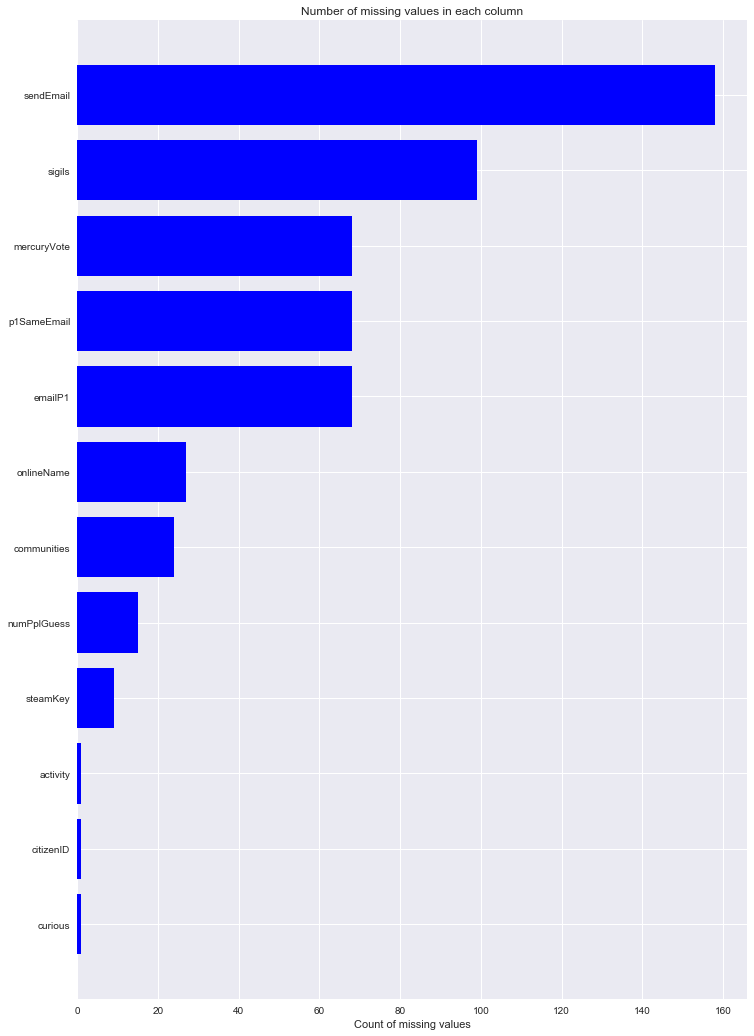

In [4]:
#There's a bunch of missing data, lets look
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [5]:
#There's also bunch of Yes/No/Na fields. Lets change those to 1/0 to make it easlier later.
#I'm fudging it here - Yes = 1, anything else = 0
binary_columns = ['emailP1', 'p1SameEmail','mercuryVote','p2survey','lucidDream','curious',
                  'echo','coincidence','universeBeginning','simulation','singularity',
                  'physicalPass','secondSurvey','truth','redButton','surprise',
                  'datasetSurvey','dsAlone','finalQ','citizenID','cityOnMap',
                  'bootsectorCode','azureCode','multiEmail','enarc','enarcSameEmail',
                  'wtComplete','steamKey']

df.fillna(0,inplace=True)
#There's probably a better way, but this'll work
#Set all yes to 1, then set everything else to zero. 
for x in binary_columns:
    df[x].replace('Yes',1,inplace=True)
    df[x].replace('[^1]',0, regex=True,inplace=True)

    
#Then for the NY live event, lets have some fun
df['nyLive'].replace('Yes',1,inplace=True)
df['nyLive'].replace('Did not participate',0, inplace=True)
df['nyLive'].replace(['Periscope','Waking Titan Twitch'],0.5, inplace=True)

df.head()

,timestamp,designation,signup,sigils,emailP1,p1SameEmail,sendEmail,mercuryVote,p2survey,onlineName,...,azureCode,nyLive,multiEmail,communities,enarc,enarcSameEmail,wtComplete,steamKey,activity,numPplGuess
0,2017-08-03 17:20:36,L-15,Phase 2,0,0,0,0,0,1,"Steam ID, Discord Username",...,1,0.5,1,WakingTitan Phase 2 Discord,1,1,1,0,9.0,5000.0
1,2017-08-03 17:22:21,HG-16,Phase 1,"Sigil 1, Sigil 2, Sigil 3, Sigil 4, Sigil 5, S...",1,1,info@multiverse-75.com (With the subject line ...,1,1,Discord Username,...,1,0.5,0,"Reddit, NMS Discord",1,1,1,0,9.0,4000.0
2,2017-08-03 17:22:33,AWK,Phase 2,0,0,0,0,0,1,"Steam ID, Reddit Username, Discord Username",...,1,0.0,0,WakingTitan Phase 2 Discord,0,0,1,0,7.0,15000.0
3,2017-08-03 17:23:36,HG-16,Phase 1,"Sigil 1, Sigil 2, Sigil 3, Sigil 4, Sigil 5, S...",0,0,0,0,1,"Steam ID, PSN, Reddit Username, Discord Username",...,1,0.5,0,"Reddit, WakingTitan Phase 2 Discord",0,0,1,0,8.0,50000.0
4,2017-08-03 17:23:37,HG-16,Phase 1,"Sigil 1, Sigil 2, Sigil 3, Sigil 4, Sigil 5, S...",0,0,0,0,1,"Discord Username, The name I always use in the...",...,1,0.5,0,WakingTitan Phase 2 Discord,0,0,1,0,6.0,8000.0


c:\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


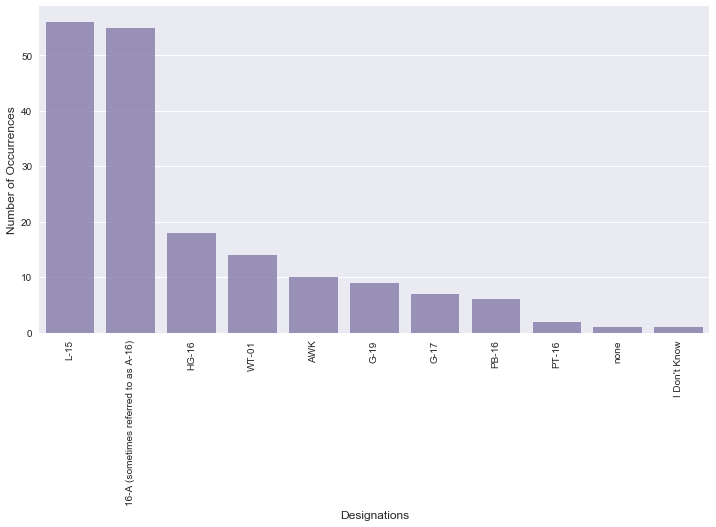

In [6]:
#lets look at the distribution of designations first
cnt_desig = df['designation'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(cnt_desig.index, cnt_desig.values, alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.xlabel('Designations', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

wow! That's not a normal or random distribution. 
But does look kinda like a pareto distribution (except for those pesky 16-A's). 




Eh, not too bad. 
Let get to some real analysis...
Starting simple with a correlation


c:\Anaconda3\lib\site-packages\seaborn\matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
c:\Anaconda3\lib\site-packages\seaborn\matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


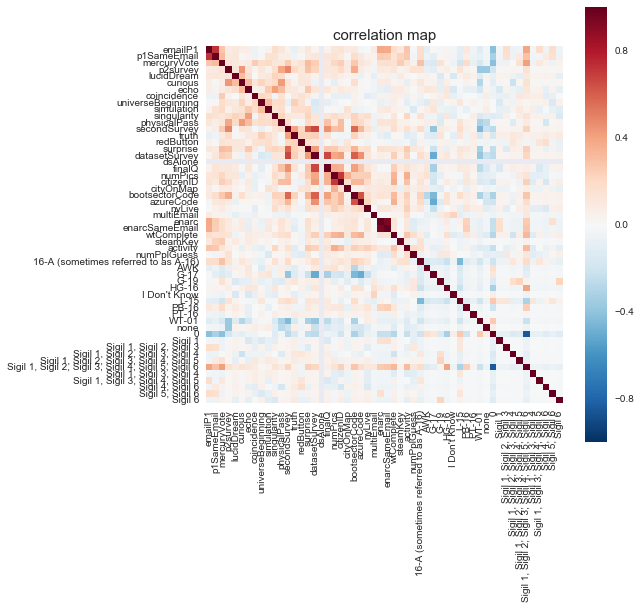

In [7]:
#Set up some dummy columns as 1/0 to represent the designations
dfa = pd.get_dummies(df['designation'])
tmp_df = df.merge(dfa,left_index=True, right_index=True)
#Then add some dummies for sigils
dfb = pd.get_dummies(df['sigils'])
tmp_df = tmp_df.merge(dfb,left_index=True, right_index=True)
corrmat = tmp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("correlation map", fontsize=15)
plt.show()

Well well well. 
We've got some interesting negative corelations for G-17 and WT-01. There's also some weighting for all sigils and HG-16. 

we could probably do some straight guesses based on that. 


In [8]:
#Maybe a pairwise plot will show something
#This can take up to 10 mins to run, uncomment if you have the time
#sns.pairplot(df , diag_kind='kde',kind='scatter',hue='designation')

In [9]:
#Prepping the data for modeling
train_y = df['designation'].values
cat_cols = ['signup','sigils','onlineName','whichFirst',
              'finalQ','communities','lifeAsGame']
train_df = df.drop(['designation','sendEmail'], axis=1) #'timestamp',
train_df = pd.get_dummies(train_df[cat_cols])
feat_names = train_df.columns.values



                                      precision    recall  f1-score   support

16-A (sometimes referred to as A-16)       0.93      0.95      0.94        55
                                 AWK       1.00      0.90      0.95        10
                                G-17       1.00      0.86      0.92         7
                                G-19       1.00      0.89      0.94         9
                               HG-16       0.95      1.00      0.97        18
                        I Don't Know       1.00      1.00      1.00         1
                                L-15       0.96      0.96      0.96        56
                               PB-16       1.00      1.00      1.00         6
                               PT-16       1.00      1.00      1.00         2
                               WT-01       0.93      1.00      0.97        14
                                none       1.00      1.00      1.00         1

                         avg / total       0.96      0.96     

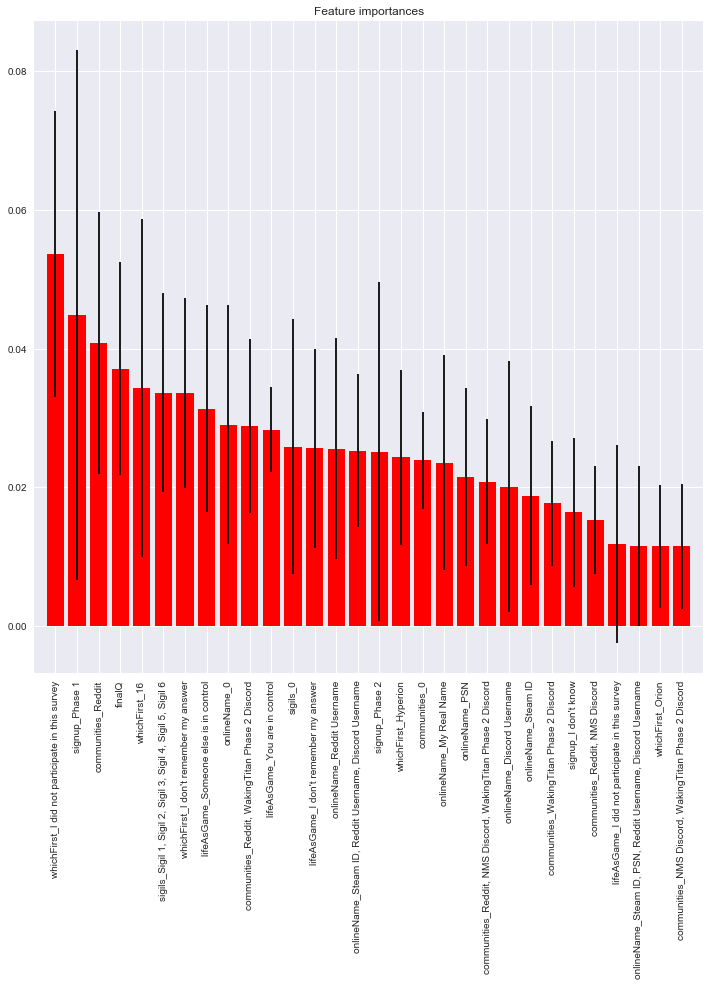

In [10]:
#Now lets try some random forests, 

model = ensemble.RandomForestClassifier(random_state=16)
model.fit(train_df, train_y)

#how well does it do at a glance - yeah, it's not a proper test
print(metrics.classification_report(train_y, model.predict(train_df)))

## plot the importances ##
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:30]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

                                      precision    recall  f1-score   support

16-A (sometimes referred to as A-16)       0.96      1.00      0.98        55
                                 AWK       1.00      0.90      0.95        10
                                G-17       0.88      1.00      0.93         7
                                G-19       1.00      1.00      1.00         9
                               HG-16       1.00      0.94      0.97        18
                        I Don't Know       1.00      1.00      1.00         1
                                L-15       1.00      1.00      1.00        56
                               PB-16       1.00      1.00      1.00         6
                               PT-16       1.00      1.00      1.00         2
                               WT-01       1.00      0.93      0.96        14
                                none       1.00      1.00      1.00         1

                         avg / total       0.98      0.98     

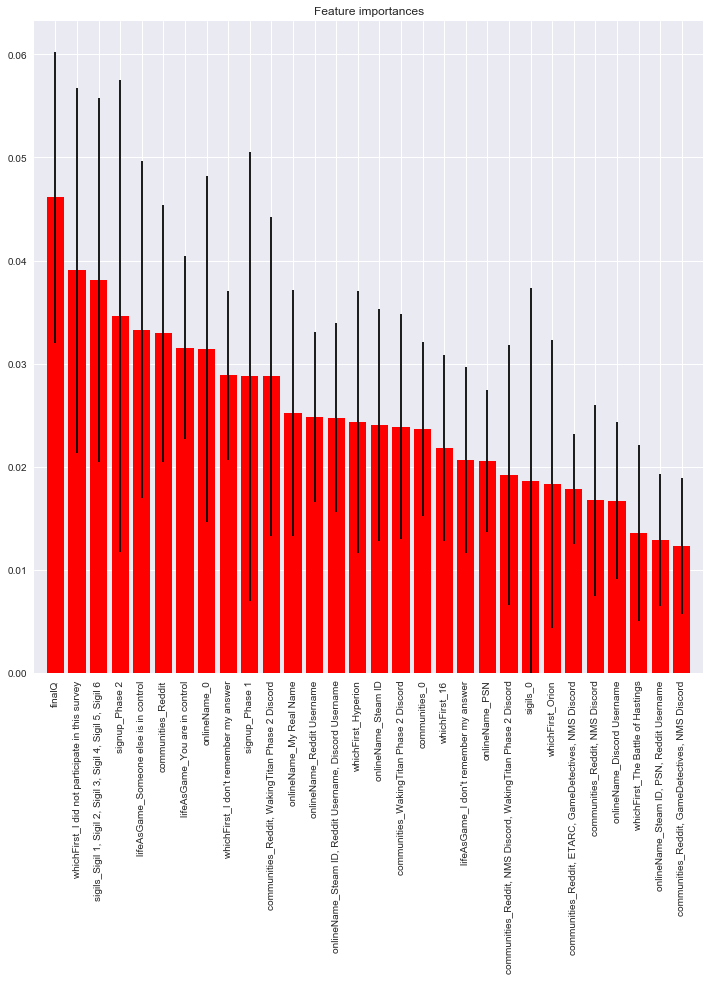

In [11]:
#And some extra trees, 

model = ensemble.ExtraTreesClassifier(random_state=16)
model.fit(train_df, train_y)

#how well does it do at a glance - yeah, it's not a proper test.
#print(metrics.confusion_matrix(train_y, model.predict(train_df)))
print(metrics.classification_report(train_y, model.predict(train_df)))

## plot the importances ##
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:30]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

                                      precision    recall  f1-score   support

16-A (sometimes referred to as A-16)       0.95      0.98      0.96        55
                                 AWK       1.00      0.90      0.95        10
                                G-17       1.00      0.86      0.92         7
                                G-19       1.00      1.00      1.00         9
                               HG-16       0.95      1.00      0.97        18
                        I Don't Know       1.00      1.00      1.00         1
                                L-15       1.00      0.96      0.98        56
                               PB-16       1.00      1.00      1.00         6
                               PT-16       1.00      1.00      1.00         2
                               WT-01       0.93      1.00      0.97        14
                                none       1.00      1.00      1.00         1

                         avg / total       0.97      0.97     

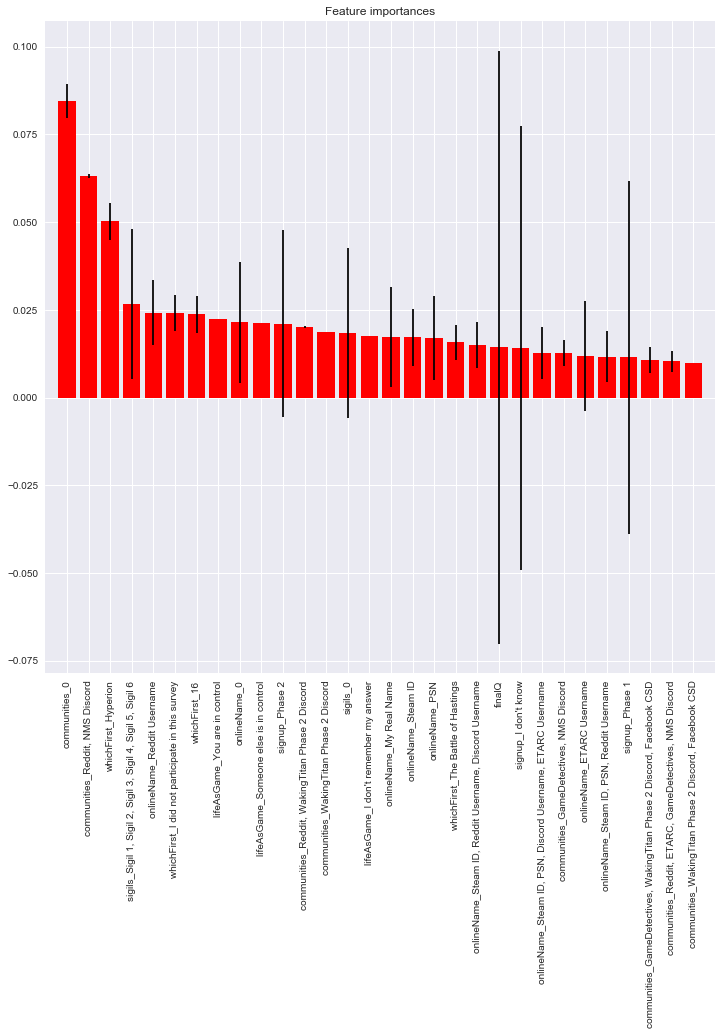

In [12]:
#and for a different model
model = ensemble.GradientBoostingClassifier(random_state=16)
model.fit(train_df, train_y)

#how well does it do at a glance - warning not a proper test.
print(metrics.classification_report(train_y, model.predict(train_df)))

## plot the importances ##
feat_imp = pd.Series(model.feature_importances_, train_df.columns).sort_values(ascending=False)
#feat_imp.plot(kind='bar', title='Feature Importances')
#plt.ylabel('Feature Importance Score')

importances = model.feature_importances_
indices = np.argsort(importances)[::-1][:30]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=feat_imp[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

c:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                                      precision    recall  f1-score   support

16-A (sometimes referred to as A-16)       0.69      0.84      0.75        55
                                 AWK       1.00      0.60      0.75        10
                                G-17       1.00      0.71      0.83         7
                                G-19       0.50      0.11      0.18         9
                               HG-16       0.65      0.72      0.68        18
                        I Don't Know       0.00      0.00      0.00         1
                                L-15       0.75      0.80      0.78        56
                               PB-16       0.75      0.50      0.60         6
                               PT-16       0.00      0.00      0.00         2
                               WT-01       0.86      0.86      0.86        14
                                none       1.00      1.00      1.00         1

                         avg / total       0.73      0.74     

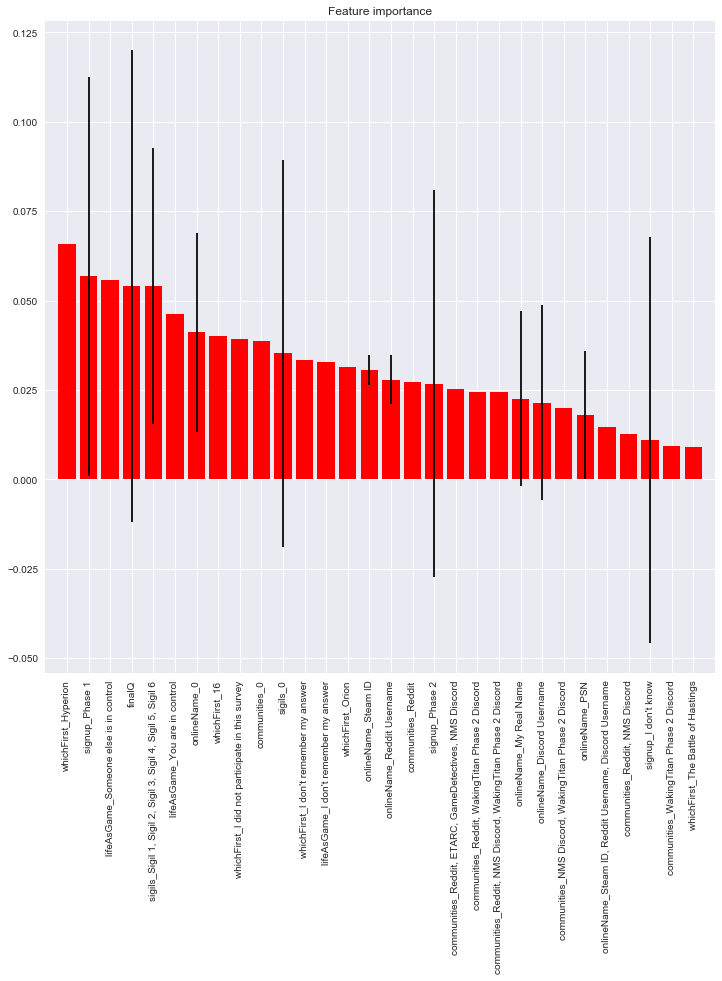

In [13]:
#And now the current Kaggle favourite

model = xgb.XGBClassifier()
model = model.fit(train_df,train_y)

#how well does it do at a glance - yeah, its not a proper test.
print(metrics.classification_report(train_y, model.predict(train_df)))

# plot the important features #
feat_imp = pd.Series(model.feature_importances_, train_df.columns).sort_values(ascending=False)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1][:30]

plt.figure(figsize=(12,12))
plt.title("Feature importance")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=feat_imp[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()



In [14]:
#and because every statician will be loas without it
model = linear_model.LogisticRegression()
model.fit(train_df, train_y)
print(metrics.classification_report(train_y, model.predict(train_df)))


                                      precision    recall  f1-score   support

16-A (sometimes referred to as A-16)       0.58      0.76      0.66        55
                                 AWK       1.00      0.20      0.33        10
                                G-17       1.00      0.57      0.73         7
                                G-19       1.00      0.22      0.36         9
                               HG-16       0.54      0.39      0.45        18
                        I Don't Know       0.00      0.00      0.00         1
                                L-15       0.62      0.77      0.69        56
                               PB-16       1.00      0.67      0.80         6
                               PT-16       0.00      0.00      0.00         2
                               WT-01       0.83      0.71      0.77        14
                                none       0.00      0.00      0.00         1

                         avg / total       0.67      0.64     

c:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Average guess of the Number of Parcipants: 20777.55


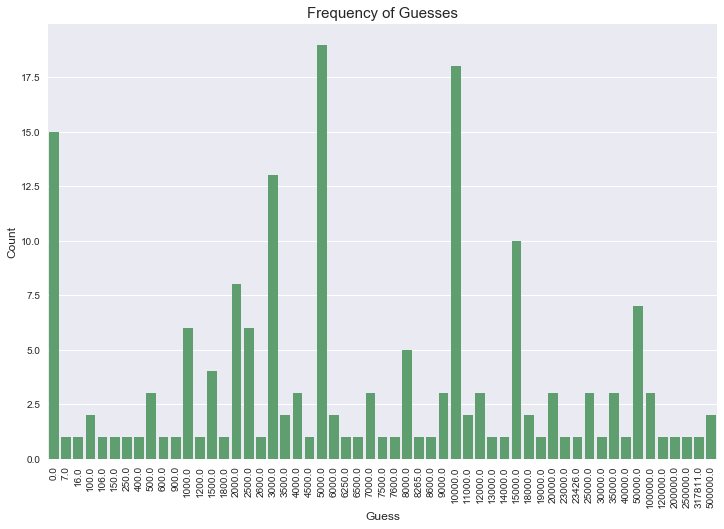

In [15]:
#Thought I might also have a look at our guesses for the number of ARG players
#as this often gives a good approximation of the actual value
print("Average guess of the Number of Parcipants: %.2f" % df['numPplGuess'].mean())

#The first look at random forests showed this as the 
plt.figure(figsize=(12,8))
sns.countplot(x="numPplGuess", data=df, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Guess', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Guesses", fontsize=15)
plt.show()